In [ ]:
import os
import urllib.request
import requests
import shutil
import pandas as pd
import torch
import torch.nn as nn

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
#import features from google drive
# List files in the current directory
files = os.listdir('/content/drive/My Drive/ExpertAdvice')
print(files)
googleDriveFolderPath = "/content/drive/My Drive/ExpertAdvice"

['cloud.data', 'spambase', 'cloudDataset.csv', 'spambaseDataset.csv', 'expertAdviceFeature Extraction.ipynb', 'normalisedCloudDataset.csv', 'normalisedSpambaseDataset.csv', 'expertAdviceNormalisation.ipynb', 'ExpertAdviceModel.ipynb']


In [ ]:
dataset = pd.read_csv(googleDriveFolderPath+"/normalisedCloudDataset.csv")

In [ ]:
dataset.shape

(2048, 10)

In [ ]:
#import dataset
features_size = dataset.shape[1]
numberOfExperts = 6
print(features_size)

10


In [ ]:
tensor_data = torch.tensor(dataset.values)
shuffled_tensor_data = tensor_data[torch.randperm(tensor_data.size(0))]
print("Shape of shuffled tensor:", shuffled_tensor_data.shape)

Shape of shuffled tensor: torch.Size([2048, 10])


In [ ]:
# debugging cell
shuffled_tensor_data

tensor([[-0.6534, -2.0812, -1.4223,  ...,  1.4443,  1.0094,  1.1516],
        [-0.3439, -0.6723, -0.4823,  ..., -1.0747, -0.7032, -0.8539],
        [-0.5210, -1.0724, -1.0401,  ...,  1.2461,  0.9776,  1.0926],
        ...,
        [-0.6093, -0.4592, -0.7831,  ...,  1.1553,  1.0094,  1.0783],
        [-0.4767, -0.6255, -1.0033,  ..., -0.5285, -0.6998, -0.5744],
        [-0.4577,  0.2037,  0.0557,  ..., -0.6943, -0.7049, -0.6872]],
       dtype=torch.float64)

In [ ]:
'''
define a class for representing experts
variables:
2 variables tuples for representing 2 clusters, and corresponding number of assigned datapoints = 0 in begining(eventually will assign the mean values of the features seen by the expert)

predict method(features) - finds the distance of features from the two clusters and return the cluster with minimum distance from the features
calculate loss(predictedCluster, features, r=constant value) - return ||(features - predictedCluster)/2*R||^2
updateClusters(features, predictedCluster) newCluster value = (assigned datapoints * old clusterValue + features) / (assigned datapoints + 1)
 and assigned datapoints += 1
'''
class Expert:
    def __init__(self, features_size):
        self.cluster1 = (torch.randn(features_size), 0)  # Tuple representing cluster1 and its number of assigned datapoints
        self.cluster2 = (torch.randn(features_size), 0)  # Tuple representing cluster2 and its number of assigned datapoints

    def predictCluster(self, features):
        # Compute the distance of features from the two clusters
        distance_cluster1 = torch.norm(features - self.cluster1[0])
        distance_cluster2 = torch.norm(features - self.cluster2[0])

        # Return the cluster with the minimum distance from the features
        if distance_cluster1 < distance_cluster2:
            return self.cluster1[0]
        else:
            return self.cluster2[0]

    def calculate_loss(self, features, predicted_cluster, r=1):
        # Calculate the loss using the formula ||(features - predicted_cluster) / (2 * r)||^2
        loss = torch.norm((features - predicted_cluster[0]) / (2 * r)) ** 2
        return loss

    def update_clusters(self, features, predicted_cluster):
        # Update the clusters based on the assigned datapoints and features
        if predicted_cluster == self.cluster1:
            updated_cluster = ((self.cluster1[0] * self.cluster1[1] + features) / (self.cluster1[1] + 1), self.cluster1[1] + 1)
            self.cluster1 = updated_cluster
        else:
            updated_cluster = ((self.cluster2[0] * self.cluster2[1] + features) / (self.cluster2[1] + 1), self.cluster2[1] + 1)
            self.cluster2 = updated_cluster


In [ ]:
# Get the maximum value and its index along the entire tensor
numberOfExperts = 6
max_value = torch.max(shuffled_tensor_data)
r = 10 * max_value.item()
experts = [Expert(features_size) for _ in range(numberOfExperts)]

In [ ]:
# Initialize learner parameters
expertLoss = torch.zeros(numberOfExperts, dtype=torch.float32)
expertPrediction = [torch.zeros(features_size, dtype=torch.float32) for _ in range(numberOfExperts)]
expertProb = torch.tensor([1/numberOfExperts] * numberOfExperts, dtype=torch.float32)
cumLossExperts = torch.zeros(numberOfExperts, dtype=torch.float32)
cumLossAlgo = torch.tensor(0.0, dtype=torch.float32)
static = 0
alpha = 0.1

In [ ]:
'''
Learner update_expert_probabilites method
input - expert loss functions, expert_probabilties
function := expert_probabilties =  expert_probabilitie * e^(-loss)
'''


def update_expert_probabilities(expertLoss, expertProb, static = 1, alpha = 0):
    if static == 1:
      #print("Static Expert Model prediction")
      # Compute the update
      updated_probs = expertProb * torch.exp(-1 * expertLoss)

      # Normalize the probabilities
      normalized_probs = nn.functional.softmax(updated_probs, dim=0)

      sum_prob = torch.sum(normalized_probs)
      if not torch.allclose(sum_prob, torch.tensor(1.0)):
          raise ValueError("The sum of updated expert probabilities is not equal to 1.")
      else:
        return normalized_probs
    else:
      #print("Fixed-alpha model prediction")
      num_experts = len(expertProb)
      updated_probs = torch.zeros_like(expertProb)

      for i in range(num_experts):
          p_i_given_j = torch.where(torch.arange(num_experts) == i, 1 - alpha, alpha / (num_experts - 1))
          updated_probs[i] = torch.sum(expertProb * torch.exp(-expertLoss) * p_i_given_j)

      normalized_probs = nn.functional.softmax(updated_probs, dim=0)
      return normalized_probs



In [ ]:
'''
learner function
aggregate_predictions(expertProb, expertPrediction)
where expertPrediction = torch.zeros(numberOfExperts, dtype=torch.float32)
expertProb = torch.tensor([1/numberOfExperts] * numberOfExperts, dtype=torch.float32) intialised already and passed on with some values

return sum(expertProb[i]*expertPrediction)

'''

def aggregate_predictions(expertProb, expertPrediction):
    # Ensure expertProb and expertPrediction have the same size
    assert len(expertProb) == len(expertPrediction)

    # Initialize the aggregated prediction tensor
    aggregated_prediction = torch.zeros_like(expertPrediction[0])

    # Iterate over each expert's prediction
    for prob, prediction in zip(expertProb, expertPrediction):
        # Perform element-wise multiplication and add to the aggregated prediction
        aggregated_prediction += prob * prediction

    return aggregated_prediction


In [ ]:
print(expertProb)

tensor([0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667])


In [ ]:
'''
define function for gettign algorithm loss using obtained aggregated prediction and label

use same loss function as experts
# Calculate loss using log likelihood method
        loss = - (label * torch.log(prediction) + (1 - label) * torch.log(1 - prediction))
        return loss
'''
def calculate_algorithm_loss(aggregated_prediction, features):
    loss = torch.norm((features - aggregated_prediction) / (2 * r)) ** 2
    return loss

In [ ]:
cumLossAlgo_plot = []
cumExpertLoss_plot1 = []
cumExpertLoss_plot2 = []
cumExpertLoss_plot3 = []
cumExpertLoss_plot4 = []
cumExpertLoss_plot5 = []
cumExpertLoss_plot6 = []

for datapoint in shuffled_tensor_data:
    # Extract features and label
    features = datapoint

    # Loop through each expert
    for i, expert in enumerate(experts):
        # Make prediction using expert model
        prediction = expert.predictCluster(features)
        expertPrediction[i] = prediction

        # Calculate loss and update expertLoss
        loss = expert.calculate_loss(features, prediction, r)
        cumLossExperts[i] += loss.item()
        if i == 0:
          cumExpertLoss_plot1.append(cumLossExperts[i].item())
        elif i == 1:
          cumExpertLoss_plot2.append(cumLossExperts[i].item())
        elif i == 2:
          cumExpertLoss_plot3.append(cumLossExperts[i].item())
        elif i == 3:
          cumExpertLoss_plot4.append(cumLossExperts[i].item())
        elif i == 4:
          cumExpertLoss_plot5.append(cumLossExperts[i].item())
        else:
          cumExpertLoss_plot6.append(cumLossExperts[i].item())


        expertLoss[i] = loss

        # Update weights of the expert based on the loss
        expert.update_clusters(features, prediction)


    # Update expertProb using previous expertProb and expert loss
    expertProb = update_expert_probabilities(expertProb, expertLoss, 1, 0.5)
    # Aggregate losses to make a final prediction

    final_prediction = aggregate_predictions(expertProb, expertPrediction)
    # Cummulative loss for the algorithm
    cumLossAlgo += calculate_algorithm_loss(final_prediction, features)
    #print(cumLossAlgo)
    cumLossAlgo_plot.append(cumLossAlgo.item())

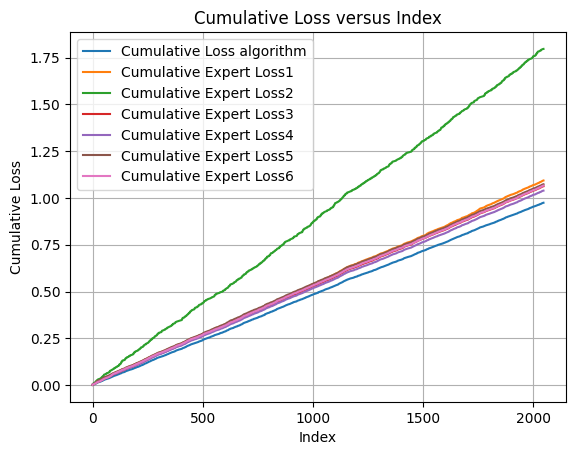

In [ ]:
# Create a list of index values corresponding to the length of cumLossAlgo_plot
indices = list(range(len(cumLossAlgo_plot)))

# Plot cumLossAlgo_plot versus its index value
plt.plot(indices, cumLossAlgo_plot, label='Cumulative Loss algorithm')
plt.plot(indices, cumExpertLoss_plot1, label='Cumulative Expert Loss1')  # Add the second plot
plt.plot(indices, cumExpertLoss_plot2, label='Cumulative Expert Loss2')  # Add the second plot
plt.plot(indices, cumExpertLoss_plot3, label='Cumulative Expert Loss3')  # Add the second plot
plt.plot(indices, cumExpertLoss_plot4, label='Cumulative Expert Loss4')  # Add the second plot
plt.plot(indices, cumExpertLoss_plot5, label='Cumulative Expert Loss5')  # Add the second plot
plt.plot(indices, cumExpertLoss_plot6, label='Cumulative Expert Loss6')  # Add the second plot
plt.xlabel('Index')
plt.ylabel('Cumulative Loss')
plt.title('Cumulative Loss versus Index')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
cumLossAlgo_plot[-1]

0.9704649448394775

In [ ]:
FixedAlpha_2 = cumLossAlgo_plot[:]

In [ ]:
StaticAlpha = cumLossAlgo_plot[:]

In [ ]:
FixedAlpha_1 = cumLossAlgo_plot[:]

In [ ]:
FixedAlpha_3 = cumLossAlgo_plot[:]

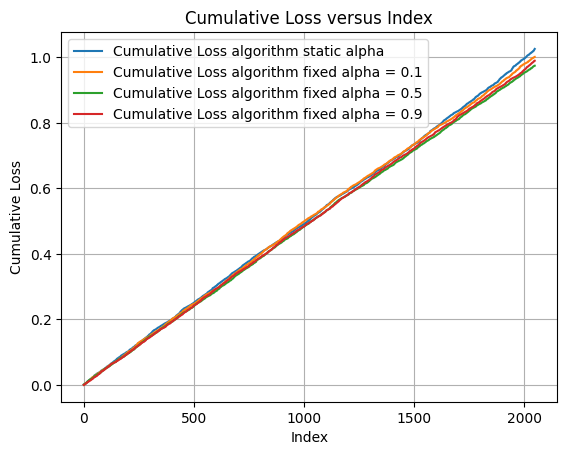

In [ ]:
# Create a list of index values corresponding to the length of cumLossAlgo_plot
indices = list(range(len(cumLossAlgo_plot)))

# Plot cumLossAlgo_plot versus its index value
plt.plot(indices, StaticAlpha, label='Cumulative Loss algorithm static alpha')
plt.plot(indices, FixedAlpha_1, label='Cumulative Loss algorithm fixed alpha = 0.1')  # Add the second plot
plt.plot(indices, FixedAlpha_2, label='Cumulative Loss algorithm fixed alpha = 0.5')  # Add the second plot
plt.plot(indices, FixedAlpha_3, label='Cumulative Loss algorithm fixed alpha = 0.9')  # Add the second plot

plt.xlabel('Index')
plt.ylabel('Cumulative Loss')
plt.title('Cumulative Loss versus Index')
plt.legend()
plt.grid(True)
plt.show()